# С медианным фильтром

In [3]:
import numpy as np
import re
import scipy.io as spio
from scipy.interpolate import interp1d
import math

import matplotlib.pyplot as plt
import statistics

def med_filt(x, n):
    a = [elem for elem in x]
    for i in range(n, len(x)-n-1):
        a[i]=(statistics.median(x[i-n:i+n+1]))
    return a


def readTextTable(file_name, head_lines=0, cmpl=False):
    e = ''
# Check comsol text file ------------------------------------------------------
    try:
        f = open(file_name, "r")
    except IOError:
        e = ("Error! Cannot open file ""%s"" !") % file_name
        Data = np.array([], float)
        return (Data,e)
    #end_try
# -----------------------------------------------------------------------------

# Read data from file ---------------------------------------------------------
    lines_all = f.readlines()                                                   # read all string lines in the file and save to the list 'lines_all'
    f.close()

    str_list = re.split('\s+', lines_all[head_lines])                           # split line into 'words'
    str_list = list(filter(None, str_list))                                     # remove '' from the list

    cols = len(str_list)
    rows = len(lines_all)-head_lines

    Data = np.zeros((rows, cols), complex)                                   # allocate memory for data

    line_idx = head_lines
    i = 0
    for line in lines_all[head_lines:]:
        str_list = re.split('\s+', line.replace('i', 'j'))                      # split line into 'words'
        str_list = list(filter(None, str_list))                                 # remove '' from the list
        try:                                                                    # check whether all words in the line are numeric values
            data_list = [complex(s) for s in str_list]
        except (ValueError, IndexError):
            e += "Incorrect data in line %d !" % (line_idx)
            if not cmpl: Data = np.real(Data)
            return (Data,e)
        #end_try

        if len(data_list) == cols:
            Data[i,:] = np.array(data_list, complex)
        else:
            e += "Incorrect data in line %d !" % (line_idx)
            if not cmpl: Data = np.real(Data)
            return (Data,e)
        #end_if

        i += 1
        line_idx += 1
    #end_for

    if not cmpl: Data = np.real(Data)
    return (Data,e)
#end_def
#
# *****************************************************************************

def savemat(file_name, data):
    e = ""
    try:
        f = open(file_name, "w")
    except IOError:
        e = ("Error! Cannot open file ""%s"" to write!") % file_name
        return (e)
    #end_try
    f.close()

    spio.savemat(file_name, data);
    return (e)
#end_def
#
# *****************************************************************************

#fname_lfp_bkg = r"e:\Work\SNL Spinner\FlowLoop-11.2021\25-11-2021 Chorus9-Slim_Chorus10\Averaging_SNL10a_1461_24.11.2021_bkg-LFP.txt"

fname_lfp = r"C:\TGT\1.02.2022\Averaging_SNL10a_1461_24.11.2021-LFP.txt"
fname_hfp = r"C:\TGT\1.02.2022\Averaging_SNL10a_1461_24.11.2021-HFP.txt"

#fname_bkg = r"e:\Work\SNL Spinner\FlowLoop-11.2021\25-11-2021 Chorus9-Slim_Chorus10\Averaging_SNL10a_1461_24.11.2021_bkg-HFP.txt"


Q = [0, 0, 15, 5, 10.3, 15.2, 17.2, 10.7, 22.7, 30.5, 40.6, 50.2, 61.6, 70, 79.7, 92, 103.3, 123.8, 141.4, 160 ]
Q = np.array(Q, float)

def dBToPow(data):
    return 10**(data/10)


# Read signal + background + resonant noise data (LFP)
raw_lfp,_ = readTextTable(fname_lfp)

freq_lfp = raw_lfp[0,:]
raw_lfp = raw_lfp[1:,:].squeeze()


# Read signal + background + resonant noise data (HFP)
raw_hfp,_ = readTextTable(fname_hfp)

freq_hfp = raw_hfp[0,:]
raw_hfp = raw_hfp[1:,:].squeeze()

qc_idx = [True, True, False, False, False, False, True, True, True, True, True, True, True, True, True, False, True, True, True, True]
Q = Q[qc_idx]
raw_hfp = raw_hfp[qc_idx]
raw_lfp = raw_lfp[qc_idx]


rate_idx = np.argsort(Q)
raw_hfp = raw_hfp[rate_idx]
raw_lfp = raw_lfp[rate_idx]
Q = Q[rate_idx]


raw_hfp = np.array(med_filt(raw_hfp,20))
raw_lfp = np.array(med_filt(raw_lfp,10))

raw_lfp = dBToPow(raw_lfp)
raw_lfp_bkg = raw_lfp[1,:] 
raw_lfp = raw_lfp[1:,:]
raw_hfp = dBToPow(raw_hfp)   
raw_hfp_bkg = raw_hfp[1,:] 
raw_hfp = raw_hfp[1:,:]
Q = Q[1:]

'''
stations = len(Q)
lfp = raw_lfp - np.tile(raw_lfp_bkg, [stations,1])
hfp = raw_hfp - np.tile(raw_hfp_bkg, [stations,1])

idx_4kHz = freq_hfp >= 4.0 
hfp = hfp[:,idx_4kHz]

freq_lfp_new = freq_hfp[freq_hfp < 4.0]
interp = interp1d(freq_lfp, lfp)
lfp_new = interp(freq_lfp_new)

hfp_new = np.hstack((lfp_new, hfp))


# Sound power on the flow rate
snl_pow = np.sum(hfp_new[:,1:], axis=1)

####

conf = 10   # index of upper confident flow rate
plt.plot(Q[:conf], snl_pow[:conf], 'bo')
plt.plot(Q[conf:], snl_pow[conf:], 'mo')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(' log10(N)    ',
              fontsize = 15,    #  размер шрифта
              color = 'black')     #  ширина крайней линии


plt.xlabel(' log10(V) ',
              fontsize = 15,
              color = 'black')
plt.grid()
'''


"\nstations = len(Q)\nlfp = raw_lfp - np.tile(raw_lfp_bkg, [stations,1])\nhfp = raw_hfp - np.tile(raw_hfp_bkg, [stations,1])\n\nidx_4kHz = freq_hfp >= 4.0 \nhfp = hfp[:,idx_4kHz]\n\nfreq_lfp_new = freq_hfp[freq_hfp < 4.0]\ninterp = interp1d(freq_lfp, lfp)\nlfp_new = interp(freq_lfp_new)\n\nhfp_new = np.hstack((lfp_new, hfp))\n\n\n# Sound power on the flow rate\nsnl_pow = np.sum(hfp_new[:,1:], axis=1)\n\n####\n\nconf = 10   # index of upper confident flow rate\nplt.plot(Q[:conf], snl_pow[:conf], 'bo')\nplt.plot(Q[conf:], snl_pow[conf:], 'mo')\nplt.xscale('log')\nplt.yscale('log')\nplt.ylabel(' log10(N)    ',\n              fontsize = 15,    #  размер шрифта\n              color = 'black')     #  ширина крайней линии\n\n\nplt.xlabel(' log10(V) ',\n              fontsize = 15,\n              color = 'black')\nplt.grid()\n"

<IPython.core.display.Javascript object>


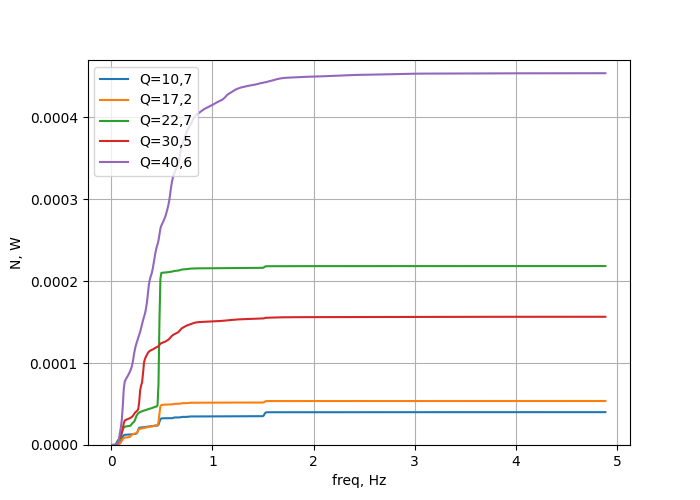

In [4]:
%matplotlib notebook

def pow_freq(a):
    return [sum(raw_lfp[a,:i]) for i in range(512)]

a = freq_lfp[:]

plt.figure(figsize=(7, 5))
plt.plot(a, pow_freq(1), a, pow_freq(2), a, pow_freq(3), a, pow_freq(4), a, pow_freq(5))
plt.grid()

plt.legend(('Q=10,7', 'Q=17,2', 'Q=22,7', 'Q=30,5', 'Q=40,6'))
plt.xlabel('freq, Hz')
plt.ylabel('N, W')
#plt.xscale('log')
#plt.yscale('log')
plt.ylim(0, 47*10**(-5))

plt.show()

<IPython.core.display.Javascript object>


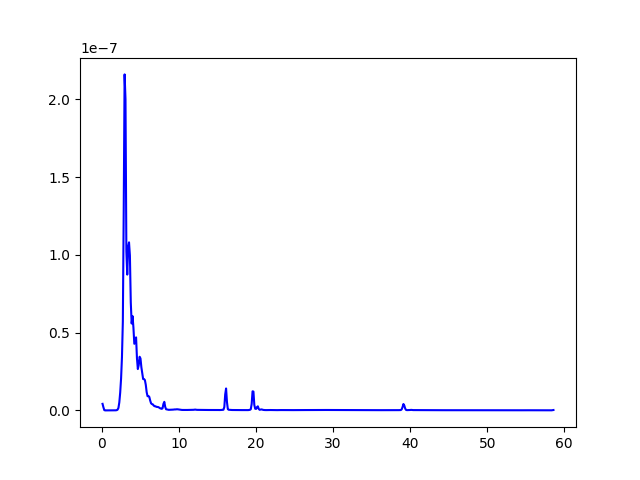

NameError: name 'model' is not defined

In [7]:
%matplotlib notebook

x = freq_hfp[:]
fig, ax = plt.subplots() 

for i in range(1,2,1):
    ax.plot(x, raw_hfp[5], 'b')
    ax.plot(x, np.matmul(model,stolb), 'r')
    plt.yscale('log')
    plt.vlines(x[106], 10**(-10), 10**(-7), 'red')
    plt.vlines(x[125], 10**(-10), 10**(-7), 'red')
    plt.vlines(x[139], 10**(-10), 10**(-7), 'red')
    plt.vlines(x[165], 10**(-10), 10**(-7), 'red')
    plt.vlines(x[307], 10**(-10), 10**(-7), 'red')
    plt.vlines(x[329], 10**(-10), 10**(-7), 'red')
    plt.vlines(x[40], 10**(-10), 10**(-7), 'red')
    plt.vlines(x[46], 10**(-10), 10**(-7), 'red')
    plt.vlines(x[481], 3*10**(-11), 10**(-7), 'red')
    ax.legend(['N(f) after filtering, Q=30.5',])
plt.grid()
ax.set_xlabel(' freq, kHz    ',
              fontsize = 15,    #  размер шрифта
              color = 'black')     #  ширина крайней линии


ax.set_ylabel(' N, W  ',
              fontsize = 15,
              color = 'black')

plt.show() 


In [319]:
Q

array([  0. ,  10.7,  17.2,  22.7,  30.5,  40.6,  50.2,  61.6,  70. ,
        79.7, 103.3, 123.8, 141.4, 160. ])

In [6]:
%matplotlib notebook
from scipy import interpolate
import math

model_spline = np.hstack((raw_hfp[4, 27:67], raw_hfp[4, 74:133], raw_hfp[4, 152:166], raw_hfp[4, 194:334], raw_hfp[4, 356:508]))
model_freq = np.hstack((freq_hfp[27:67], freq_hfp[74:133], freq_hfp[152:166], freq_hfp[194:334], freq_hfp[356:508]))
model_spline = med_filt(model_spline, 10)


interp = interp1d(model_freq, model_spline, kind='linear')
model_freq_interp = np.array(freq_hfp[27:-6])
'''test_mod = interp(model_freq_interp)


tck = interpolate.splrep(model_freq[:], model_spline[:], k=3,s=20)
ynew = interpolate.splev(model_freq_interp, tck)

fig, ax = plt.subplots() 
lfp_med =  med_filt(raw_lfp[1], 15)

for i in range(1,2,1):
    ax.plot(freq_lfp[20:-20], raw_lfp[1][20:-20], 'b')
    ax.plot(freq_lfp[20:-20], lfp_med[20:-20], 'g')
    #ax.plot(model_freq_interp, z_ml, 'g.')
    plt.yscale('log')

plt.grid()
ax.set_xlabel(' freq, kHz    ',
              fontsize = 15,    #  размер шрифта
              color = 'black')     #  ширина крайней линии


ax.set_ylabel(' N, W  ',
              fontsize = 15,
              color = 'black')

plt.show() '''




"test_mod = interp(model_freq_interp)\n\n\ntck = interpolate.splrep(model_freq[:], model_spline[:], k=3,s=20)\nynew = interpolate.splev(model_freq_interp, tck)\n\nfig, ax = plt.subplots() \nlfp_med =  med_filt(raw_lfp[1], 15)\n\nfor i in range(1,2,1):\n    ax.plot(freq_lfp[20:-20], raw_lfp[1][20:-20], 'b')\n    ax.plot(freq_lfp[20:-20], lfp_med[20:-20], 'g')\n    #ax.plot(model_freq_interp, z_ml, 'g.')\n    plt.yscale('log')\n\nplt.grid()\nax.set_xlabel(' freq, kHz    ',\n              fontsize = 15,    #  размер шрифта\n              color = 'black')     #  ширина крайней линии\n\n\nax.set_ylabel(' N, W  ',\n              fontsize = 15,\n              color = 'black')\n\nplt.show() "

In [482]:
np.savetxt('raw_lfp[1].txt', med_filt(raw_lfp[1], 15)[20:-20])
np.savetxt('freq_lfp.txt', freq_lfp[20:-20])

In [649]:
len(freq_hfp[27:-6])

479

In [592]:
np.savetxt('model_spline.txt', model_spline)
np.savetxt('model_freq.txt', model_freq)
np.savetxt('model_freq_interp.txt', model_freq_interp)

In [121]:
print([point for point in x if point > 58.2 and point < 58.3])

for i in range(len(x)):
    if x[i] == 58.2504272:
        print(i)

[58.2504272]
481


<IPython.core.display.Javascript object>


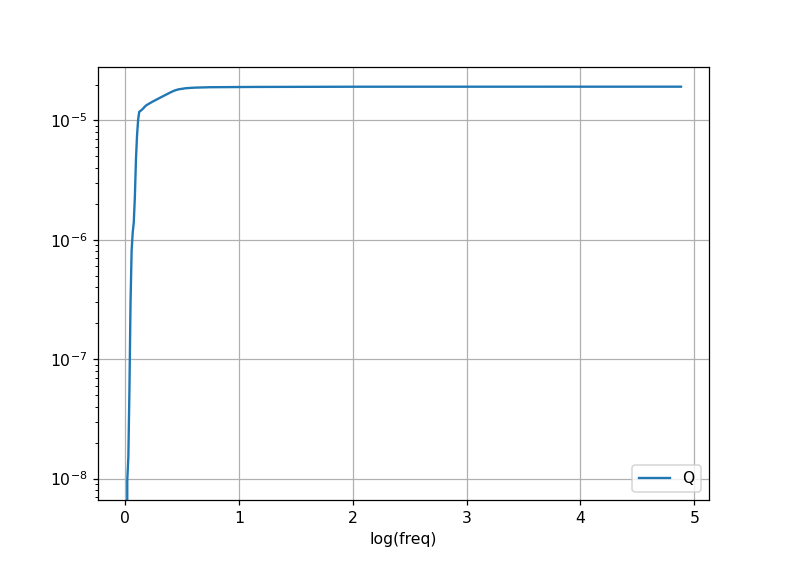

In [73]:
%matplotlib notebook

"""
По ОУ мощность шума, по ОХ частотный диапазон
"""

def pow_freq(a):
    lfp_med = np.array(med_filt(raw_lfp[a],12))
    return [sum(lfp_med[:i]) for i in range(512)]

a = freq_lfp[:]

plt.figure(figsize=(7, 5))
plt.plot(a, pow_freq(1))
plt.grid()


plt.xlabel('log(freq)')
#plt.ylabel('log(N)')
#plt.xscale('log')
plt.yscale('log')
plt.legend('Q = 10,7')

plt.show()

<IPython.core.display.Javascript object>


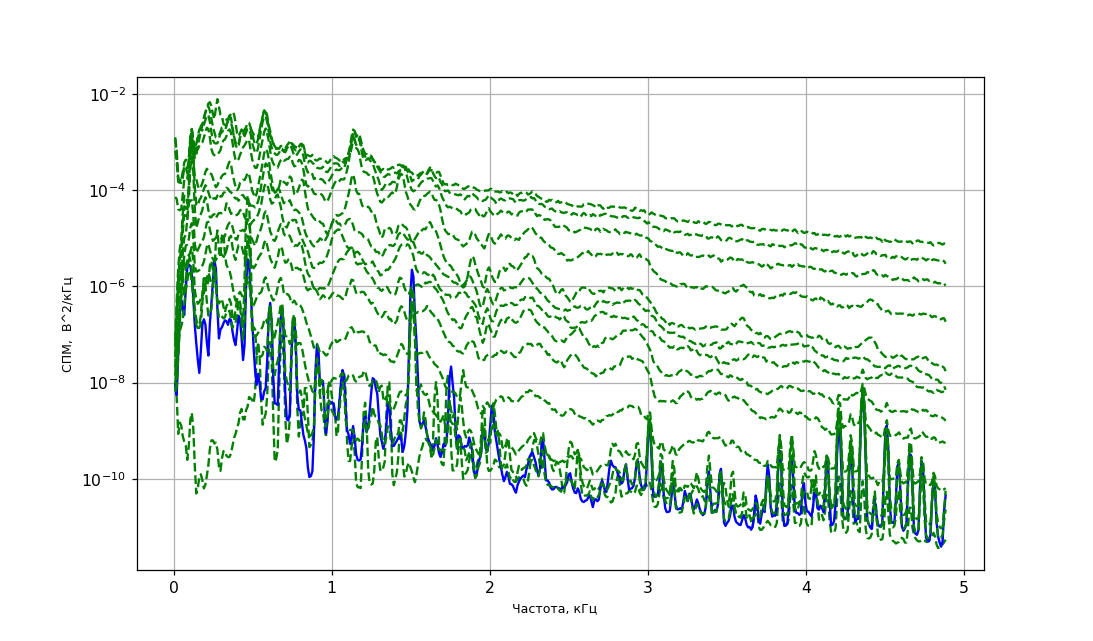

In [467]:
x = freq_lfp
fig, ax = plt.subplots() 
for i in range(len(raw_lfp)):
    if i == 1:
        ax.plot(x, raw_lfp[i], 'b')
    else:
        ax.plot(x, raw_lfp[i], 'g--')
plt.grid()
ax.set_xlabel(' Частота, кГц    ',
              fontsize = 8,    #  размер шрифта
              color = 'black')     #  ширина крайней линии


ax.set_ylabel(' СПМ,  В^2/кГц ',
              fontsize = 8,
              color = 'black')
plt.yscale('log')

plt.show() 


<IPython.core.display.Javascript object>


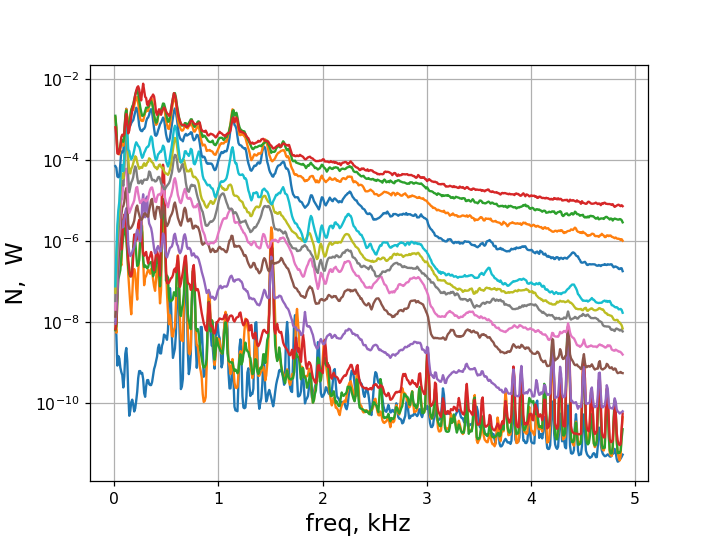

In [29]:
x = freq_lfp
fig, ax = plt.subplots() 
for i in range(len(raw_lfp)):
    if i == 4:
        ax.plot(x, raw_lfp[i])
    else:
        ax.plot(x, raw_lfp[i])
plt.grid()
ax.set_xlabel(' freq, kHz    ',
              fontsize = 15,    #  размер шрифта
              color = 'black')     #  ширина крайней линии


ax.set_ylabel(' N,  W ',
              fontsize = 15,
              color = 'black')
plt.yscale('log')

plt.show() 


In [8]:
import statistics

def med_filt(x, n):
    a = [elem for elem in x]
    for i in range(n, len(x)-n-1):
        a[i]=(statistics.median(x[i-n:i+n+1]))
    return a

In [4]:
f = open('C:\\Users\\rafil\\TGT_Jupyter\\zMLtoPY.txt', )
z_ml = []
for line in f:
    z_ml.append(float(line))

model = np.array([z_ml, [1 for i in range(479)]])
model = model.transpose()
###freq_hfp[27:-6]

In [16]:
A=[]
B=[]
Q_log = []

s=LA.pinv(model)

for i in range(14):
    A_0 = np.matmul(s,np.c_[raw_hfp[i][27:-6]])
    A.append(A_0[0,0])
    B.append(A_0[1,0])



In [47]:
np.savetxt('Q.txt', np.log10(Q[:]))
np.savetxt('A.txt', np.log10(A[:]))
np.savetxt('B.txt', np.log10(B[:]))

C:\Users\rafil\AppData\Local\Temp/ipykernel_22004/550734225.py:1: RuntimeWarning: divide by zero encountered in log10
  np.savetxt('Q.txt', np.log10(Q[:]))
C:\Users\rafil\AppData\Local\Temp/ipykernel_22004/550734225.py:3: RuntimeWarning: invalid value encountered in log10
  np.savetxt('B.txt', np.log10(B[:]))


<IPython.core.display.Javascript object>


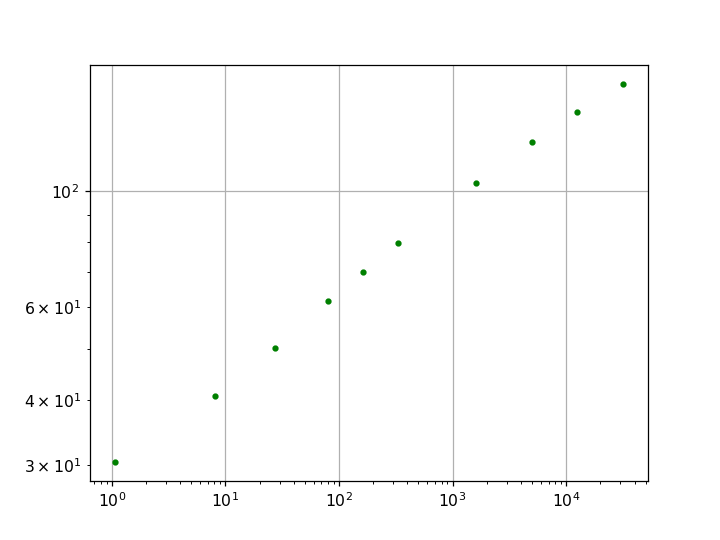

In [73]:
fig, ax = plt.subplots() 
ax.plot(A[4:], Q[4:], 'g.')
plt.grid()
plt.yscale('log')
plt.xscale('log')

plt.show() 


<IPython.core.display.Javascript object>


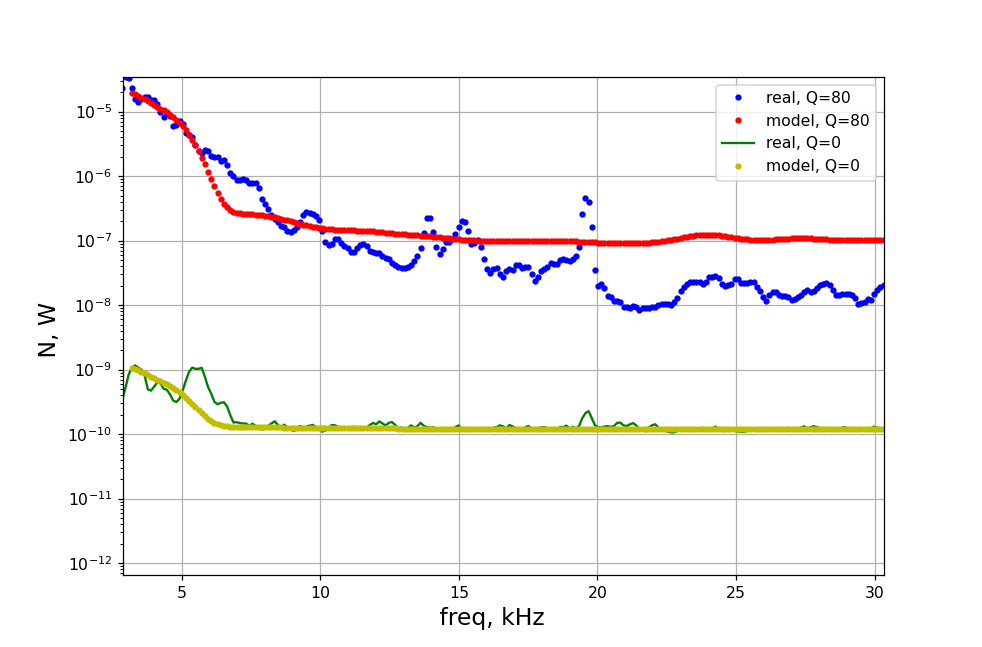

In [100]:
%matplotlib notebook

x = freq_hfp[:]
fig, ax = plt.subplots() 

for i in range(10,11,1):
    ax.plot(x, raw_hfp[i], 'b.')
    ax.plot(model_freq_interp, np.matmul(model,np.c_[[A[i]]+ [B[i]]]), 'r.')
    ax.plot(x, raw_hfp[0], 'g')
    ax.plot(model_freq_interp, np.matmul(model,np.c_[[A[0]]+ [B[0]]]), 'y.')
    ax.legend(['real, Q=80 ', 'model, Q=80', 'real, Q=0', 'model, Q=0'])
    plt.yscale('log')
plt.grid()
ax.set_xlabel(' freq, kHz    ',
              fontsize = 15,    #  размер шрифта
              color = 'black')     #  ширина крайней линии


ax.set_ylabel(' N, W  ',
              fontsize = 15,
              color = 'black')

plt.show() 


In [1]:
def error(a, b):
    err_squar = []
    for i in range(len(a)):
        err_i = abs(a[i]-b[i])
        err_squar.append(err_i/b[i]*100)
        
    return err_squar